    pip install -U requests beautifulsoup4 lxml imageio wordcloud mlxtend ckiptagger[tf,gdown] # tfgpu for GPU support


In [1]:
import requests
from datetime import datetime
# import sqlite3 # fot sqlute database support
from bs4 import BeautifulSoup

In [2]:
class Crawler:
    pttUrl = "https://www.ptt.cc"

    def __init__(self, board):
        self.board = board
        self.Articles = []
        self.boardUrl = "/bbs/{}".format(board)
        self.contents = []
#         request = requests.get(Crawler.pttUrl + self.boardUrl, cookies = {"over18": "1"})
#         if request.status_code == 404:
#             print("No such board")
#             return
#         pageText = crawler.pageText.split("r-list-sep")[0]
#         self.pageText = request.text
        
    def getToday(self, date=None, pageNext=None, keyword=None, num_posts=100):
        if pageNext == None:
            pageNext = self.boardUrl
        request = requests.get(Crawler.pttUrl + pageNext, cookies = {"over18": "1"})
        if request.status_code == 404:
            print("No such board")
            return
        self.pageText = request.text
        soup = BeautifulSoup(self.pageText, "lxml")
        pageNext = soup.find("div", "btn-group btn-group-paging").find_all("a")[1].attrs["href"]
        if date == None:
            date = datetime(2020, 2, 12) 
        pageText = self.pageText.split("r-list-sep")[0]
        soup = BeautifulSoup(pageText, "lxml")
        for post in soup.select("div.r-ent"):
            url = post.find("div", "title").a
            if url == None:
                continue
            else:
                url = post.find("div", "title").a.attrs["href"]
            articleTxt = requests.get(Crawler.pttUrl + url, cookies = {"over18": "1"}).text
            articleSoup = BeautifulSoup(articleTxt, "lxml")
            title = articleSoup.find("title").text  # 標題
            content = articleSoup.find("meta", property="og:description").get("content")  # 文章內容
            if title == None or content == None:
                continue
            if keyword != None:
                if title.find(keyword) < 0 and content.find(keyword) < 0:
                    continue
            print(Crawler.pttUrl + url)
#             print(type(title))
            self.contents.append(title + ":" + content)
#             self.contents.append(content)
            push_list = []
            for push in articleSoup.find_all("span", class_="push-content"):
                if len(push.text[2:]) <= 0:
                    continue
                push_list.append(push.text[2:])  # 推文
            self.contents.append(push_list)  
            time_str = post.find("div", "date").text.strip()
            time_obj = datetime.strptime(time_str+"/2020", '%m/%d/%Y')
            #if True:  # 一篇文章
            if time_obj < date:  # 不是今天的文章
                return
        else:
            if len(self.contents)/2 > num_posts:
                return
            print(pageNext)
            self.getToday(date, pageNext, keyword, num_posts)
            

In [3]:
board = "gossiping"
crawler = Crawler(board)
crawler.getToday(keyword="陳時中", num_posts=10)

https://www.ptt.cc/bbs/Gossiping/M.1581493874.A.F14.html
https://www.ptt.cc/bbs/Gossiping/M.1581494267.A.885.html
/bbs/Gossiping/index39262.html
https://www.ptt.cc/bbs/Gossiping/M.1581493473.A.749.html
https://www.ptt.cc/bbs/Gossiping/M.1581493578.A.79C.html
/bbs/Gossiping/index39261.html
https://www.ptt.cc/bbs/Gossiping/M.1581493049.A.6F3.html
/bbs/Gossiping/index39260.html
/bbs/Gossiping/index39259.html
https://www.ptt.cc/bbs/Gossiping/M.1581491549.A.8A3.html
https://www.ptt.cc/bbs/Gossiping/M.1581491825.A.8C3.html
/bbs/Gossiping/index39258.html
https://www.ptt.cc/bbs/Gossiping/M.1581491106.A.770.html
https://www.ptt.cc/bbs/Gossiping/M.1581491275.A.D8A.html
/bbs/Gossiping/index39257.html
https://www.ptt.cc/bbs/Gossiping/M.1581490757.A.EE7.html
/bbs/Gossiping/index39256.html
https://www.ptt.cc/bbs/Gossiping/M.1581490241.A.BE3.html
https://www.ptt.cc/bbs/Gossiping/M.1581490320.A.961.html
https://www.ptt.cc/bbs/Gossiping/M.1581490456.A.6E4.html


In [67]:
print(len(crawler.contents))

78


In [4]:
import tensorflow as tf
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER

import os
import sys

# Suppress as many warnings as possible
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
# from tensorflow.python.util import deprecation
# deprecation._PRINT_DEPRECATION_WARNINGS = False
# import tensorflow as tf
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
ws = WS("./data", disable_cuda=False)
pos = POS("./data", disable_cuda=False)
ner = NER("./data", disable_cuda=False)


In [5]:
word_sentence_list = ws(
    crawler.contents,
    sentence_segmentation=True, # To consider delimiters
    segment_delimiter_set = {",", "。", ":", "?", "!", ";", ".", "（", "）", "", "()", " [",
        "] ", ":", "", "》"}, # This is the defualt set of delimiters
#     recommend_dictionary = dictionary1, # words in this dictionary are encouraged
#     coerce_dictionary = dictionary2, # words in this dictionary are forced
)

pos_sentence_list = pos(word_sentence_list)

entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

del ws
del pos
del ner

In [70]:
def print_word_pos_sentence(word_sentence, pos_sentence):
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence):
        print(f"{word}({pos})", end="\u3000")
    print()
    return
    
for i, sentence in enumerate(word_sentence_list):
    print()
    print(f"'{sentence}'")
    print_word_pos_sentence(word_sentence_list[i],  pos_sentence_list[i])
    for entity in sorted(entity_sentence_list[i]):
        print(entity)


'['Re', ':', ' [', '新聞', '] ', '首度', '延考', ' ', '大學', '指考', '確定', '延至', '7/3-7/5', ' - ', '看板', ' Gossiping - ', '批踢踢', '實業坊', ':', '1', '.', '媒體', '來源', ':', '\n※ ', '例如', '蘋果日報', '、', '自由時報', '（', '請', '參考', '版規', '下方', '的', '核准', '媒體', '名單', '）', '\nETTODAY\n2', '.', '記者署', '名\n', '※ ', '沒有', '在', '這', '打上', '記者', '署名', '的', '新聞', '會', '被', '水桶', '14', '天', ' ', '編輯', '非', '記者', '\n']'
Re(FW)　:(COLONCATEGORY)　 [(FW)　新聞(Na)　] (FW)　首度(D)　延考(VA)　 (WHITESPACE)　大學(Nc)　指考(Na)　確定(VK)　延至(VC)　7/3-7/5(Nd)　 - (FW)　看板(Na)　 Gossiping - (FW)　批踢踢(Na)　實業坊(Nc)　:(COLONCATEGORY)　1(Neu)　.(PERIODCATEGORY)　媒體(Na)　來源(Na)　:(COLONCATEGORY)　
※ (FW)　例如(P)　蘋果日報(Nb)　、(PAUSECATEGORY)　自由時報(Nb)　（(PARENTHESISCATEGORY)　請(VF)　參考(VC)　版規(Na)　下方(Ncd)　的(DE)　核准(VE)　媒體(Na)　名單(Na)　）(PARENTHESISCATEGORY)　
ETTODAY
2(Nb)　.(DOTCATEGORY)　記者署(Nb)　名
(Na)　※ (FW)　沒有(D)　在(P)　這(Nep)　打上(VC)　記者(Na)　署名(VC)　的(DE)　新聞(Na)　會(D)　被(P)　水桶(Na)　14(Neu)　天(Nf)　 (WHITESPACE)　編輯(VC)　非(A)　記者(Na)　
(WHITESPACE)　
(66, 70, 'ORG', '蘋果日報')
(71, 75, 'ORG', 

In [77]:
from collections import Counter

entity = Counter(count_list)
entity.most_common(10)

[('陳時中', 73),
 ('陳明通', 49),
 ('台灣', 46),
 ('今天', 35),
 ('中國', 34),
 ('中國人', 21),
 ('昨天', 20),
 ('陸委會', 19),
 ('陸委', 15),
 ('台灣人', 12)]

In [8]:
import pandas as pd

count_list = []
# count_dict = {}
for e in entity_sentence_list:
    for i in e:
#         count_dict[i[3]] = count_dict.get(i[3], 0) + 1
#         df = pd.concat([df, pd.DataFrame(i[3])])
        count_list.append(i[3])


In [81]:
df = pd.DataFrame(count_list, columns=["entity"])
text = df.entity.value_counts()
text.head(30)

中國      30
台灣      25
武漢      12
美國      11
今天      10
陸委會      9
一        8
五        7
昨天       7
美軍       6
阿明       5
夏威夷      5
國民黨      4
第一       4
陳時中      4
台灣人      3
解放軍      3
林奕華      3
中國人      3
蔡英文      3
50       2
溫縣       2
兩        2
陳明通      2
中共       2
11日      2
美屬       2
八卦       2
中國大陸     2
美國籍      2
Name: entity, dtype: int64

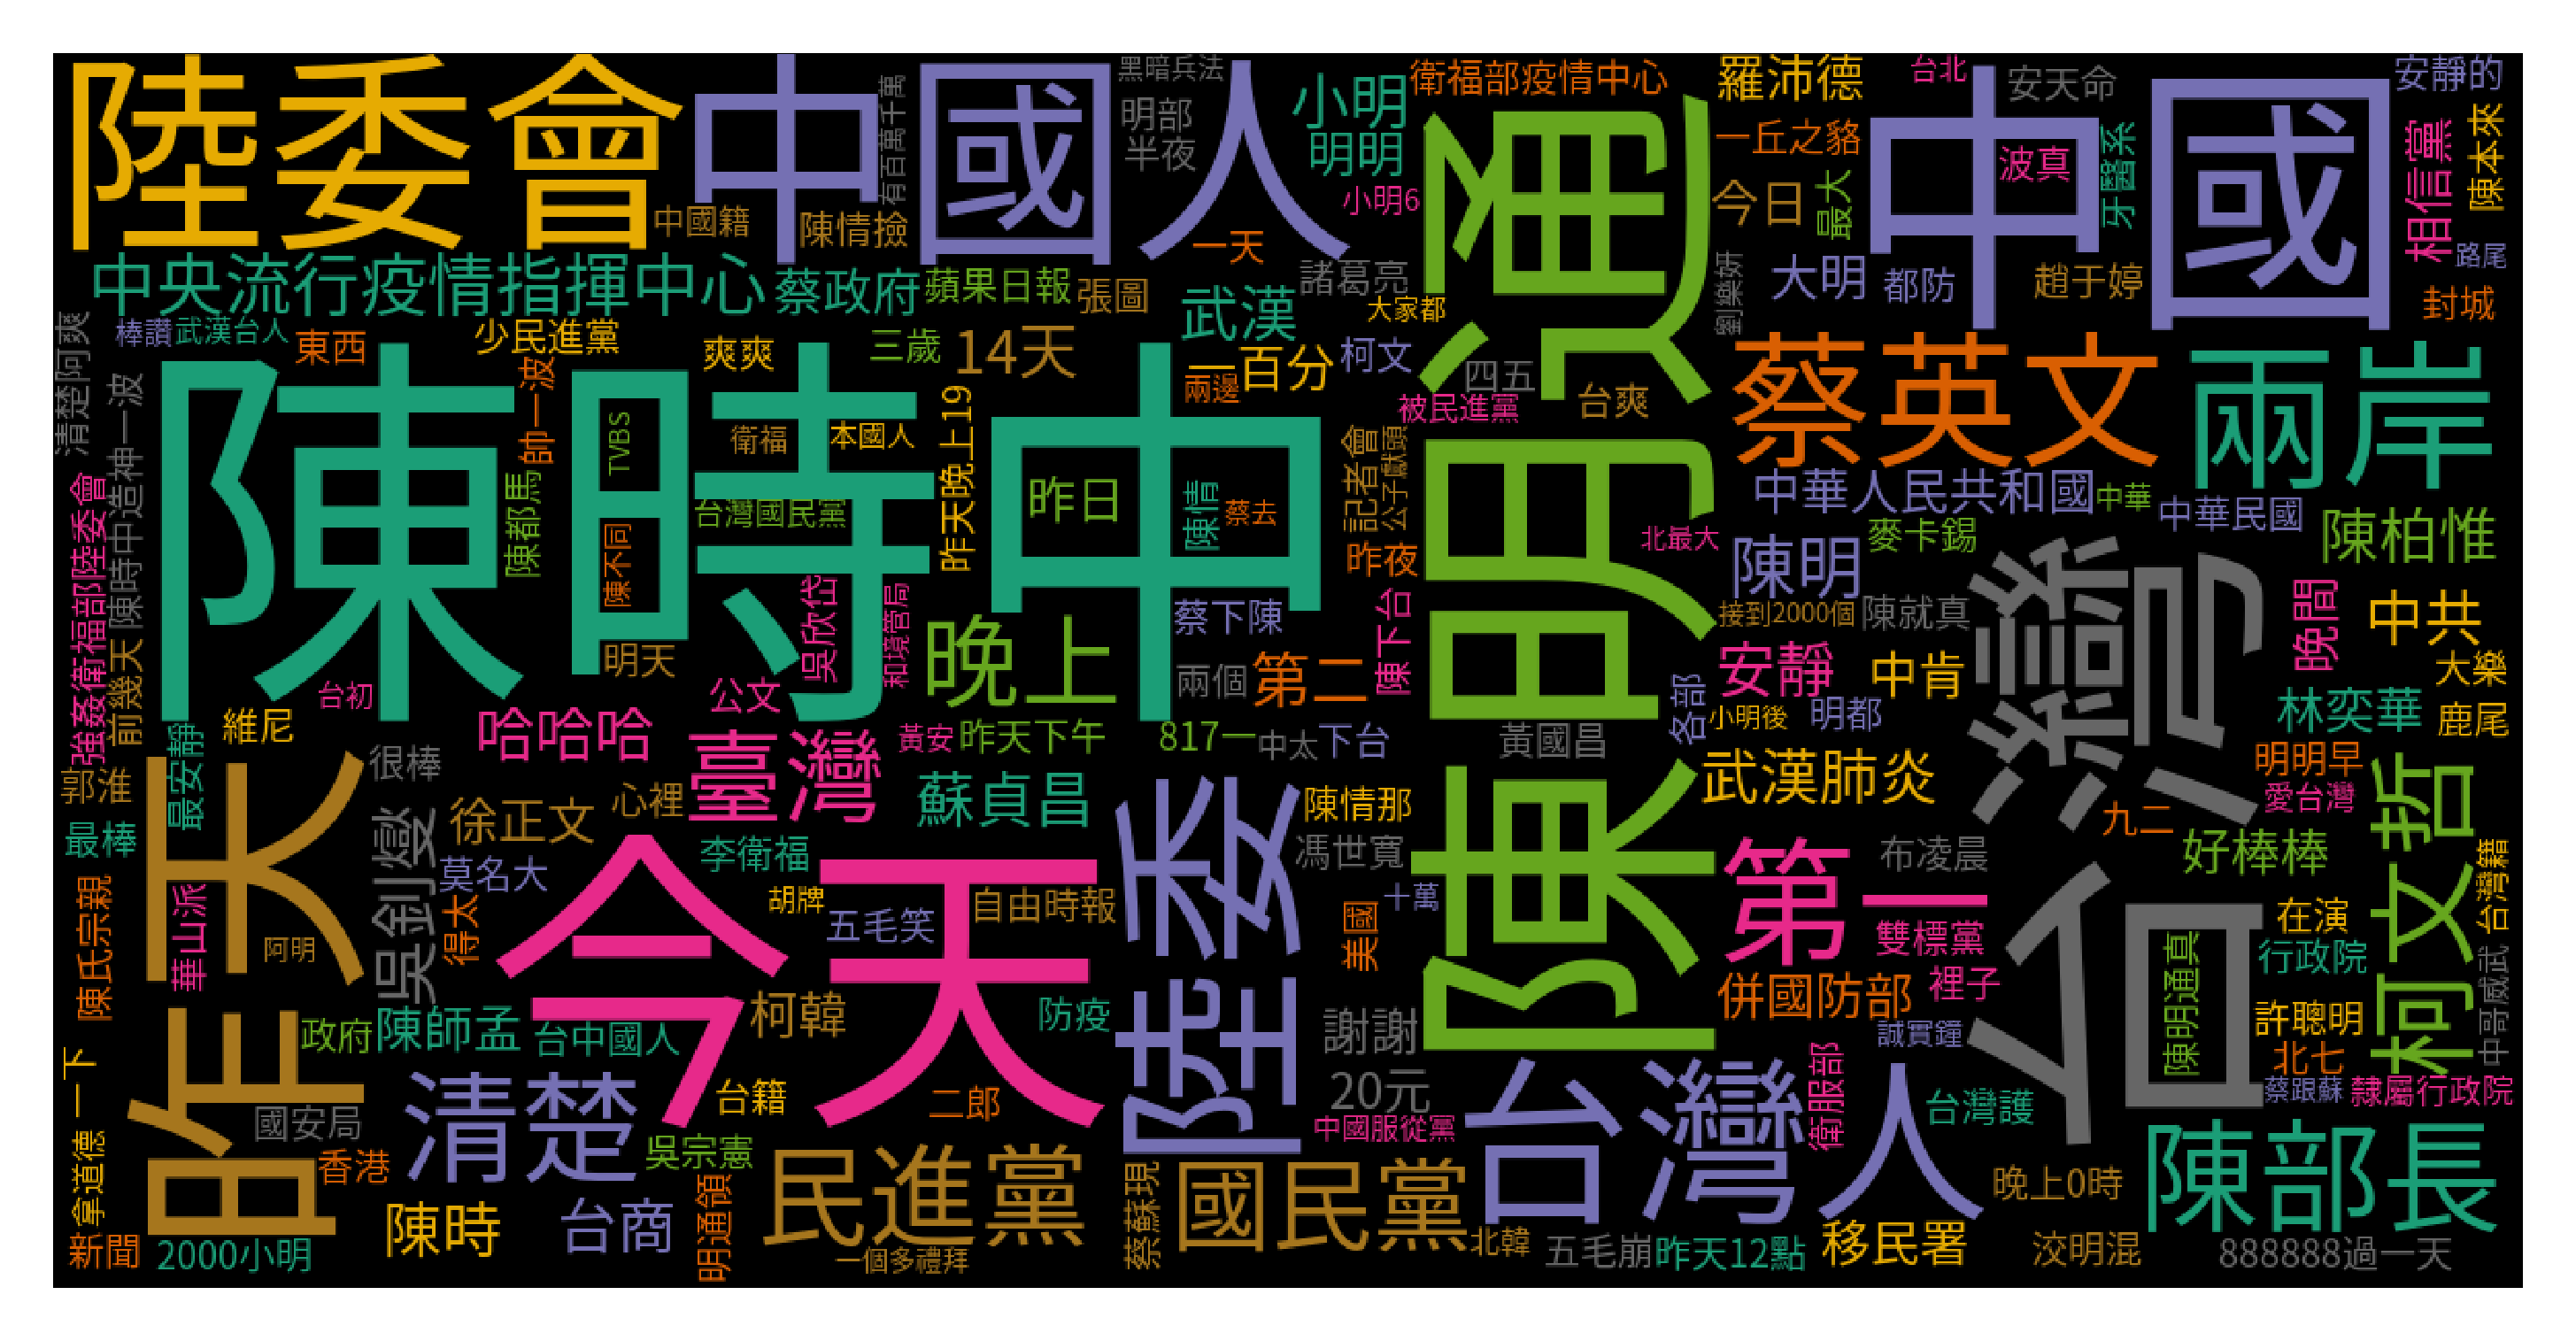

In [10]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt


text = " ".join(review for review in count_list)
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
# back_color = imageio.imread("./taiwan.png")
wordcloud = WordCloud(width=1200, height=600, max_font_size=200, max_words=200, background_color="black", 
                      font_path=font_path, colormap="Dark2").generate(text)
plt.figure(dpi=600)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()            #   須為字串且每個分詞以空白相隔


In [9]:
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd

fq_count_lists = []
# count_dict = {}
for e in entity_sentence_list:
    fq_count_list = []
    for i in e:
#         count_dict[i[3]] = count_dict.get(i[3], 0) + 1
#         df = pd.concat([df, pd.DataFrame(i[3])])
        fq_count_list.append(i[3])
    fq_count_lists.append(fq_count_list)
te = TransactionEncoder()
te_ary = te.fit(fq_count_lists).transform(fq_count_lists)
df = pd.DataFrame(te_ary, columns=te.columns_)
from mlxtend.frequent_patterns import fpgrowth
  
fpgrowth(df, min_support=0.05, use_colnames=True)

 

,support,itemsets
0,0.615385,(陳時中)
1,0.076923,(台)
2,0.346154,(今天)
3,0.269231,(昨天)
4,0.115385,(13)
...,...,...
129,0.076923,"(兩岸, 陳時中)"
130,0.076923,"(今天, 兩岸, 陸委)"
131,0.076923,"(兩岸, 陳時中, 陸委)"
132,0.076923,"(今天, 兩岸, 陳時中)"
